#### Refactoring MTS-LSTM model
* understand the dependency of the mts-lstm model in neurohydrology
* develop a skeleton model for Aibedo


In [1]:
from typing import Dict, Optional, Callable
import logging
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

from neuralhydrology.utils.config import Config
from neuralhydrology.utils.samplingutils import sample_pointpredictions
from neuralhydrology.datautils.utils import get_frequency_factor, sort_frequencies
from neuralhydrology.modelzoo.head import get_head

LOGGER = logging.getLogger(__name__)

from torch.utils.data import DataLoader

from tqdm import tqdm





In [2]:
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datasetzoo.basedataset import BaseDataset

from neuralhydrology.training.basetrainer import BaseTrainer

In [3]:
import matplotlib.pyplot as plt
import numpy as np

Refactored Abstract class

In [4]:
class BaseModel(nn.Module):
    
    # specify submodules of the model that can later be used for finetuning. Names must match class attributes
    module_parts = []

    def __init__(self, cfg: Config):
        super(BaseModel, self).__init__()
        self.cfg = cfg
        self.output_size = len(cfg.target_variables)
        # if cfg.head.lower() == 'gmm':
        #     self.output_size *= 3 * cfg.n_distributions
        # elif cfg.head.lower() == 'cmal':
        #     self.output_size *= 4 * cfg.n_distributions
        # elif cfg.head.lower() == 'umal':
        #     self.output_size *= 2

    def sample(self, data: Dict[str, torch.Tensor], n_samples: int) -> Dict[str, torch.Tensor]:
        
        return sample_pointpredictions(self, data, n_samples)

    def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        
        raise NotImplementedError

In [5]:
class MTSLSTM(BaseModel):
    
    # specify submodules of the model that can later be used for finetuning. Names must match class attributes
    module_parts = ['lstms', 'transfer_fcs', 'heads']

    def __init__(self, cfg: Config):
        super(MTSLSTM, self).__init__(cfg=cfg)
        self.lstms = None
        self.transfer_fcs = None
        self.heads = None
        self.dropout = None

        self._slice_timestep = {}
        self._frequency_factors = []

        self._seq_lengths = cfg.seq_length
        self._is_shared_mtslstm = self.cfg.shared_mtslstm  # default: a distinct LSTM per timescale
        self._transfer_mtslstm_states = self.cfg.transfer_mtslstm_states  # default: linear transfer layer
        transfer_modes = [None, "None", "identity", "linear"]
        if self._transfer_mtslstm_states["h"] not in transfer_modes \
                or self._transfer_mtslstm_states["c"] not in transfer_modes:
            raise ValueError(f"MTS-LSTM supports state transfer modes {transfer_modes}")

        if len(cfg.use_frequencies) < 2:
            raise ValueError("MTS-LSTM expects more than one input frequency")
        self._frequencies = sort_frequencies(cfg.use_frequencies)

        # start to count the number of inputs
        input_sizes = len(cfg.static_attributes + cfg.hydroatlas_attributes + cfg.evolving_attributes)

        # if is_shared_mtslstm, the LSTM gets an additional frequency flag as input.
        if self._is_shared_mtslstm:
            input_sizes += len(self._frequencies)

        if cfg.use_basin_id_encoding:
            input_sizes += cfg.number_of_basins
        if cfg.head.lower() == "umal":
            input_sizes += 1

        if isinstance(cfg.dynamic_inputs, list):
            input_sizes = {freq: input_sizes + len(cfg.dynamic_inputs) for freq in self._frequencies}
        else:
            if self._is_shared_mtslstm:
                raise ValueError(f'Different inputs not allowed if shared_mtslstm is used.')
            input_sizes = {freq: input_sizes + len(cfg.dynamic_inputs[freq]) for freq in self._frequencies}

        if not isinstance(cfg.hidden_size, dict):
            LOGGER.info("No specific hidden size for frequencies are specified. Same hidden size is used for all.")
            self._hidden_size = {freq: cfg.hidden_size for freq in self._frequencies}
        else:
            self._hidden_size = cfg.hidden_size

        if (self._is_shared_mtslstm
            or self._transfer_mtslstm_states["h"] == "identity"
            or self._transfer_mtslstm_states["c"] == "identity") \
                and any(size != self._hidden_size[self._frequencies[0]] for size in self._hidden_size.values()):
            raise ValueError("All hidden sizes must be equal if shared_mtslstm is used or state transfer=identity.")

        # create layer depending on selected frequencies
        self._init_modules(input_sizes)
        self._reset_parameters()

        # frequency factors are needed to determine the time step of information transfer
        self._init_frequency_factors_and_slice_timesteps()

    def _init_modules(self, input_sizes: Dict[str, int]):
        self.lstms = nn.ModuleDict()
        self.transfer_fcs = nn.ModuleDict()
        self.heads = nn.ModuleDict()
        self.dropout = nn.Dropout(p=self.cfg.output_dropout)
        for idx, freq in enumerate(self._frequencies):
            freq_input_size = input_sizes[freq]

            if self._is_shared_mtslstm and idx > 0:
                self.lstms[freq] = self.lstms[self._frequencies[idx - 1]]  # same LSTM for all frequencies.
                self.heads[freq] = self.heads[self._frequencies[idx - 1]]  # same head for all frequencies.
            else:
                self.lstms[freq] = nn.LSTM(input_size=freq_input_size, hidden_size=self._hidden_size[freq])
                self.heads[freq] = get_head(self.cfg, n_in=self._hidden_size[freq], n_out=self.output_size)

            if idx < len(self._frequencies) - 1:
                for state in ["c", "h"]:
                    if self._transfer_mtslstm_states[state] == "linear":
                        self.transfer_fcs[f"{state}_{freq}"] = nn.Linear(self._hidden_size[freq],
                                                                         self._hidden_size[self._frequencies[idx + 1]])
                    elif self._transfer_mtslstm_states[state] == "identity":
                        self.transfer_fcs[f"{state}_{freq}"] = nn.Identity()
                    else:
                        pass

    def _init_frequency_factors_and_slice_timesteps(self):
        for idx, freq in enumerate(self._frequencies):
            if idx < len(self._frequencies) - 1:
                frequency_factor = get_frequency_factor(freq, self._frequencies[idx + 1])
                if frequency_factor != int(frequency_factor):
                    raise ValueError('Adjacent frequencies must be multiples of each other.')
                self._frequency_factors.append(int(frequency_factor))
                # we want to pass the state of the day _before_ the next higher frequency starts,
                # because e.g. the mean of a day is stored at the same date at 00:00 in the morning.
                slice_timestep = int(self._seq_lengths[self._frequencies[idx + 1]] / self._frequency_factors[idx])
                self._slice_timestep[freq] = slice_timestep

    def _reset_parameters(self):
        if self.cfg.initial_forget_bias is not None:
            for freq in self._frequencies:
                hidden_size = self._hidden_size[freq]
                self.lstms[freq].bias_hh_l0.data[hidden_size:2 * hidden_size] = self.cfg.initial_forget_bias

    def _prepare_inputs(self, data: Dict[str, torch.Tensor], freq: str) -> torch.Tensor:
        """Concat all different inputs to the time series input"""
        suffix = f"_{freq}"
        # transpose to [seq_length, batch_size, n_features]
        x_d = data[f'x_d{suffix}'].transpose(0, 1)

        # concat all inputs
        if f'x_s{suffix}' in data and 'x_one_hot' in data:
            x_s = data[f'x_s{suffix}'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_one_hot = data['x_one_hot'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_s, x_one_hot], dim=-1)
        elif f'x_s{suffix}' in data:
            x_s = data[f'x_s{suffix}'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_s], dim=-1)
        elif 'x_one_hot' in data:
            x_one_hot = data['x_one_hot'].unsqueeze(0).repeat(x_d.shape[0], 1, 1)
            x_d = torch.cat([x_d, x_one_hot], dim=-1)
        else:
            pass

        if self._is_shared_mtslstm:
            # add frequency one-hot encoding
            idx = self._frequencies.index(freq)
            one_hot_freq = torch.zeros(x_d.shape[0], x_d.shape[1], len(self._frequencies)).to(x_d)
            one_hot_freq[:, :, idx] = 1
            x_d = torch.cat([x_d, one_hot_freq], dim=2)

        return x_d

    def forward(self, data: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """Perform a forward pass on the MTS-LSTM model.
        
        Parameters
        ----------
        data : Dict[str, torch.Tensor]
            Input data for the forward pass. See the documentation overview of all models for details on the dict keys.
        Returns
        -------
        Dict[str, torch.Tensor]
            Model predictions for each target timescale.
        """
        x_d = {freq: self._prepare_inputs(data, freq) for freq in self._frequencies}

        # initial states for lowest frequencies are set to zeros
        batch_size = x_d[self._frequencies[0]].shape[1]
        lowest_freq_hidden_size = self._hidden_size[self._frequencies[0]]
        h_0_transfer = x_d[self._frequencies[0]].new_zeros((1, batch_size, lowest_freq_hidden_size))
        c_0_transfer = torch.zeros_like(h_0_transfer)

        outputs = {}
        for idx, freq in enumerate(self._frequencies):
            if idx < len(self._frequencies) - 1:
                # get predictions and state up to the time step of information transfer
                slice_timestep = self._slice_timestep[freq]
                lstm_output_slice1, (h_n_slice1, c_n_slice1) = self.lstms[freq](x_d[freq][:-slice_timestep],
                                                                                (h_0_transfer, c_0_transfer))

                # project the states through a hidden layer to the dimensions of the next LSTM
                if self._transfer_mtslstm_states["h"] is not None:
                    h_0_transfer = self.transfer_fcs[f"h_{freq}"](h_n_slice1)
                if self._transfer_mtslstm_states["c"] is not None:
                    c_0_transfer = self.transfer_fcs[f"c_{freq}"](c_n_slice1)

                # get predictions of remaining part and concat results
                lstm_output_slice2, _ = self.lstms[freq](x_d[freq][-slice_timestep:], (h_n_slice1, c_n_slice1))
                lstm_output = torch.cat([lstm_output_slice1, lstm_output_slice2], dim=0)

            else:
                # for highest frequency, we can pass the entire sequence at once
                lstm_output, _ = self.lstms[freq](x_d[freq], (h_0_transfer, c_0_transfer))

            head_out = self.heads[freq](self.dropout(lstm_output.transpose(0, 1)))
            outputs.update({f'{key}_{freq}': value for key, value in head_out.items()})

        return outputs

In [94]:
for idx, freq in enumerate(mymodel._frequencies):
    print(idx, freq)

0 1D
1 1H


In [97]:
mymodel._slice_timestep

{'1D': 14}

In [99]:
mymodel._seq_lengths

{'1D': 365, '1H': 336}

In [98]:
get_frequency_factor('1D', '1H')

24.0

Define the configuration file as par neuralhydrology format
* need to understand which features will be helpful Aibedo

In [6]:
conf_obj = Config(Path('mytest_basin.yml'))

In [7]:
conf_obj.as_dict()

{'experiment_name': 'test_run',
 'use_frequencies': ['1H', '1D'],
 'train_basin_file': PosixPath('1_basin.txt'),
 'validation_basin_file': PosixPath('1_basin.txt'),
 'test_basin_file': PosixPath('1_basin.txt'),
 'train_start_date': Timestamp('1999-10-01 00:00:00'),
 'train_end_date': Timestamp('2008-09-30 00:00:00'),
 'validation_start_date': Timestamp('1996-10-01 00:00:00'),
 'validation_end_date': Timestamp('1999-09-30 00:00:00'),
 'test_start_date': Timestamp('1989-10-01 00:00:00'),
 'test_end_date': Timestamp('1996-09-30 00:00:00'),
 'device': 'cpu',
 'validate_every': 5,
 'validate_n_random_basins': 1,
 'metrics': ['NSE'],
 'model': 'mtslstm',
 'shared_mtslstm': False,
 'transfer_mtslstm_states': {'h': 'linear', 'c': 'linear'},
 'head': 'regression',
 'output_activation': 'linear',
 'hidden_size': 20,
 'initial_forget_bias': 3,
 'output_dropout': 0.4,
 'optimizer': 'Adam',
 'loss': 'MSE',
 'regularization': ['tie_frequencies'],
 'learning_rate': {0: 0.01, 30: 0.005, 40: 0.001},
 '

In [8]:
conf_obj.head.upper()

'REGRESSION'

In [9]:
trainer = BaseTrainer(cfg=conf_obj)

2022-02-24 10:31:19,548: Logging to /Users/shazarika/OneDrive - PARC/Projects/AiBEDO/codebase/aibedo/TemporalModels/standalone/runs/test_run_2402_103119/output.log initialized.
2022-02-24 10:31:19,549: ### Folder structure created at /Users/shazarika/OneDrive - PARC/Projects/AiBEDO/codebase/aibedo/TemporalModels/standalone/runs/test_run_2402_103119
2022-02-24 10:31:19,550: ### Run configurations for test_run
2022-02-24 10:31:19,550: experiment_name: test_run
2022-02-24 10:31:19,551: use_frequencies: ['1H', '1D']
2022-02-24 10:31:19,552: train_basin_file: 1_basin.txt
2022-02-24 10:31:19,553: validation_basin_file: 1_basin.txt
2022-02-24 10:31:19,554: test_basin_file: 1_basin.txt
2022-02-24 10:31:19,555: train_start_date: 1999-10-01 00:00:00
2022-02-24 10:31:19,556: train_end_date: 2008-09-30 00:00:00
2022-02-24 10:31:19,557: validation_start_date: 1996-10-01 00:00:00
2022-02-24 10:31:19,557: validation_end_date: 1999-09-30 00:00:00
2022-02-24 10:31:19,558: test_start_date: 1989-10-01 00

In [10]:
trainer.initialize_training()

2022-02-24 10:31:54,830: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2022-02-24 10:31:54,834: Loading basin data into xarray data set.
100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
2022-02-24 10:31:55,618: Create lookup table and convert to pytorch tensor
100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


In [11]:
trainer.device

device(type='cpu')

In [235]:
trainer.cfg.is_finetuning

False

In [13]:
trainer._scaler

{'xarray_feature_scale': <xarray.Dataset>
 Dimensions:                             ()
 Data variables: (12/17)
     convective_fraction_nldas_hourly    float64 0.12
     longwave_radiation_nldas_hourly     float64 59.98
     potential_energy_nldas_hourly       float64 189.9
     potential_evaporation_nldas_hourly  float64 0.199
     prcp(mm/day)_maurer_extended        float64 6.349
     pressure_nldas_hourly               float64 874.5
     ...                                  ...
     tmax(C)_maurer_extended             float64 10.48
     tmin(C)_maurer_extended             float64 10.14
     total_precipitation_nldas_hourly    float64 0.6986
     vp(Pa)_maurer_extended              float64 461.8
     wind_u_nldas_hourly                 float64 3.63
     wind_v_nldas_hourly                 float64 3.797,
 'xarray_feature_center': <xarray.Dataset>
 Dimensions:                             ()
 Data variables: (12/17)
     convective_fraction_nldas_hourly    float32 0.02477
     longwave_

In [12]:
ds = get_dataset(cfg=conf_obj, period="train", is_train=True)

2022-02-24 10:33:12,129: Loading basin data into xarray data set.
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
2022-02-24 10:33:12,750: Create lookup table and convert to pytorch tensor
100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


In [13]:
import pandas as pd
import xarray

In [14]:
ds._netcdf_datasets.keys()

dict_keys(['nldas_hourly'])

In [15]:
len(ds.__getitem__(1000))

4

In [16]:
ds = trainer._get_dataset()

2022-02-24 10:33:22,222: Loading basin data into xarray data set.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
2022-02-24 10:33:22,691: Create lookup table and convert to pytorch tensor
100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


In [17]:
print(ds.lookup_table[0])
print(ds.lookup_table[1])
print(ds.lookup_table[2])
print(ds.lookup_table[3])
print(ds.lookup_table[4])

print(ds.lookup_table[2737])

print(ds.lookup_table[2738])

('01022500', [8759, 364])
('01022500', [8783, 365])
('01022500', [8807, 366])
('01022500', [8831, 367])
('01022500', [8855, 368])
('01022500', [87623, 3650])
('01022500', [87647, 3651])


In [18]:
all_ds_start_id_D = []
all_ds_start_id_H = []

for i in range(len(ds)):
    all_ds_start_id_D.append(ds.lookup_table[i][1][1])
    all_ds_start_id_H.append(ds.lookup_table[i][1][0])

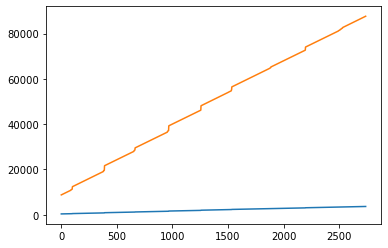

In [49]:
plt.plot(all_ds_start_id_D)
plt.plot(all_ds_start_id_H)

In [282]:
np.save("H_lookup.npy", np.array(all_ds_start_id_H))
np.save("D_lookup.npy", np.array(all_ds_start_id_D))


In [21]:
len(ds)

2739

In [22]:
print(ds.seq_len)
print(ds.frequencies)

[336, 365]
['1H', '1D']


In [23]:
for freq, seq_len, idx in zip(ds.frequencies, ds.seq_len, [8759, 364]):
    print(freq, seq_len, idx)

1H 336 8759
1D 365 364


In [24]:
print(ds.x_d['01022500']['1H'].shape)
print(ds.x_d['01022500']['1D'].shape)

print(ds.y['01022500']['1H'].shape)
print(ds.y['01022500']['1D'].shape)

torch.Size([87648, 16])
torch.Size([3652, 5])
torch.Size([87648, 1])
torch.Size([3652, 1])


### Storing the numpy arrays seperately 

In [241]:
x_d_1H_array = ds.x_d['01022500']['1H'].numpy()
x_d_1D_array = ds.x_d['01022500']['1D'].numpy()

y_1H_array = ds.y['01022500']['1H'].numpy()
y_1D_array = ds.y['01022500']['1D'].numpy()

np.save("x_d_1H_array.npy", x_d_1H_array)
np.save("x_d_1D_array.npy", x_d_1D_array)

np.save("y_1H_array.npy", y_1H_array)
np.save("y_1D_array.npy", y_1D_array)



In [56]:
ds.frequencies

['1H', '1D']

## Also get the validation and test dataset

In [30]:
ds_validate = get_dataset(cfg=conf_obj, period="validation", is_train=False)
ds_test = get_dataset(cfg=conf_obj, period="test", is_train=False)

In [31]:
print(len(ds), len(ds_validate), len(ds_test))

2739 1095 2557


In [36]:
print("TRAIN:", ds.dates)
print("VAL:", ds_validate.dates)
print("TEST:", ds_test.dates)

TRAIN: {'01022500': {'start_dates': [Timestamp('1999-10-01 00:00:00')], 'end_dates': [Timestamp('2008-09-30 00:00:00')]}}
VAL: {'01022500': {'start_dates': [Timestamp('1996-10-01 00:00:00')], 'end_dates': [Timestamp('1999-09-30 00:00:00')]}}
TEST: {'01022500': {'start_dates': [Timestamp('1989-10-01 00:00:00')], 'end_dates': [Timestamp('1996-09-30 00:00:00')]}}


In [41]:
def check_dim(dds):
    print('1H x_d shape', dds.x_d['01022500']['1H'].shape)
    print('1D x_d shape', dds.x_d['01022500']['1D'].shape)
    
    print('1H y shape', dds.y['01022500']['1H'].shape)
    print('1D y shape', dds.y['01022500']['1D'].shape)
    

In [42]:
check_dim(ds)

1H x_d shape torch.Size([87648, 16])
1D x_d shape torch.Size([3652, 5])
1H y shape torch.Size([87648, 1])
1D y shape torch.Size([3652, 1])


In [43]:
check_dim(ds_validate)

1H x_d shape torch.Size([35016, 16])
1D x_d shape torch.Size([1459, 5])
1H y shape torch.Size([35016, 1])
1D y shape torch.Size([1459, 1])


In [44]:
check_dim(ds_test)

1H x_d shape torch.Size([70104, 16])
1D x_d shape torch.Size([2921, 5])
1H y shape torch.Size([70104, 1])
1D y shape torch.Size([2921, 1])


In [50]:
# save dataset lookup

def save_lookup_tables(dds, name):
    all_dds_start_id_D = []
    all_dds_start_id_H = []

    for i in range(len(dds)):
        all_dds_start_id_D.append(dds.lookup_table[i][1][1])
        all_dds_start_id_H.append(dds.lookup_table[i][1][0])
        
    plt.plot(all_dds_start_id_D)
    plt.plot(all_dds_start_id_H)
    plt.show()
    
    np.save("H_lookup"+name+".npy", np.array(all_dds_start_id_H))
    np.save("D_lookup"+name+".npy", np.array(all_dds_start_id_D))
    

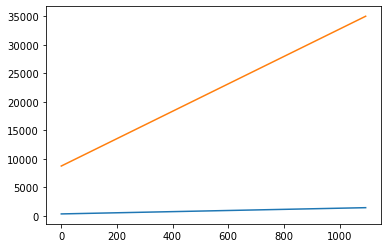

In [51]:
save_lookup_tables(ds_validate, "_val")

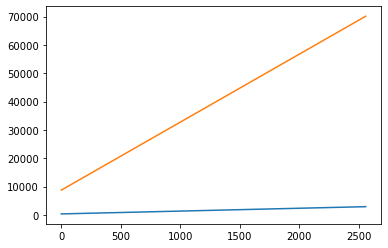

In [52]:
save_lookup_tables(ds_test, "_test")

In [53]:
# save full datasets
def save_full_data_arrays(dds, name):
    temp_x_d_1H_array = dds.x_d['01022500']['1H'].numpy()
    temp_x_d_1D_array = dds.x_d['01022500']['1D'].numpy()

    temp_y_1H_array = dds.y['01022500']['1H'].numpy()
    temp_y_1D_array = dds.y['01022500']['1D'].numpy()

    np.save("x_d_1H_array"+name+".npy", temp_x_d_1H_array)
    np.save("x_d_1D_array"+name+".npy", temp_x_d_1D_array)

    np.save("y_1H_array"+name+".npy", temp_y_1H_array)
    np.save("y_1D_array"+name+".npy", temp_y_1D_array)
    



In [54]:
save_full_data_arrays(ds_validate, "_val")

In [55]:
save_full_data_arrays(ds_test, "_test")

In [193]:
ds_sample = ds.__getitem__(1000)

In [199]:
print(ds_sample['x_d_1H'].shape)
print(ds_sample['x_d_1D'].shape)

print(ds_sample['y_1H'].shape)
print(ds_sample['y_1D'].shape)

torch.Size([336, 16])
torch.Size([365, 5])
torch.Size([336, 1])
torch.Size([365, 1])


In [198]:
ds_sample.keys()

dict_keys(['x_d_1H', 'y_1H', 'x_d_1D', 'y_1D'])

In [218]:
ds.one_hot

In [18]:
len(ds)

2739

In [202]:
ds.x_s

{}

In [24]:
len(ds[10])

4

In [27]:
ds[10].keys()

dict_keys(['x_d_1H', 'y_1H', 'x_d_1D', 'y_1D'])

In [29]:
ds[10]['x_d_1H'].shape

torch.Size([336, 16])

In [30]:
ds[10]['y_1H'].shape

torch.Size([336, 1])

In [31]:
ds[10]['x_d_1D'].shape

torch.Size([365, 5])

In [33]:
ds[10]['y_1D'].shape

torch.Size([365, 1])

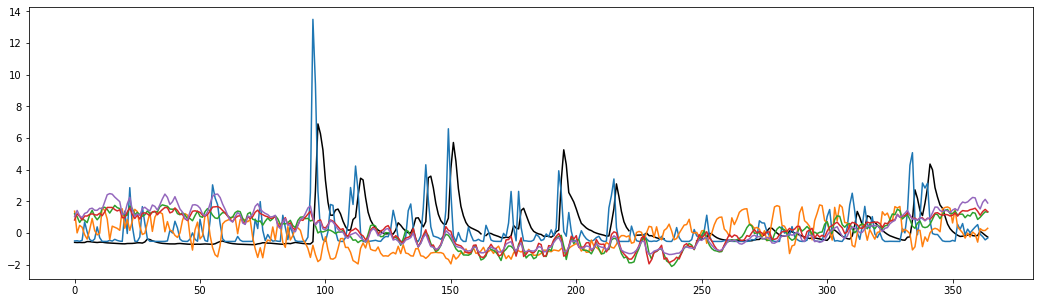

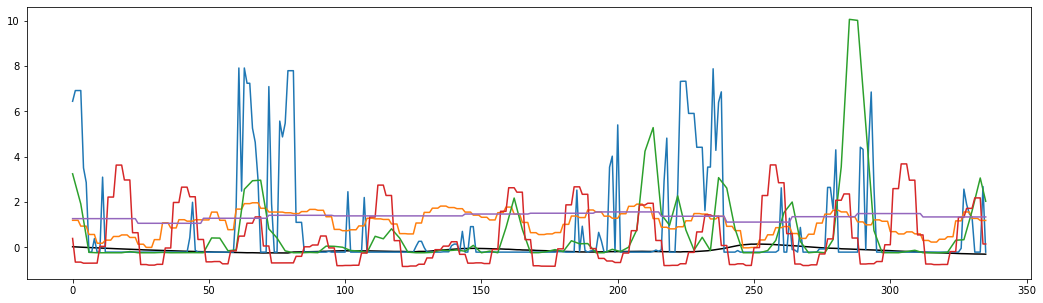

In [222]:
plt.figure(figsize=(18,5))
plt.plot(ds[2000]['y_1D'][:,0] , c='k')

plt.plot(ds[2000]['x_d_1D'][:,0])
plt.plot(ds[2000]['x_d_1D'][:,1])
plt.plot(ds[2000]['x_d_1D'][:,2])
plt.plot(ds[2000]['x_d_1D'][:,3])
plt.plot(ds[2000]['x_d_1D'][:,4])


plt.show()

plt.figure(figsize=(18,5))
plt.plot(ds[2000]['y_1H'][:,0] , c='k')

plt.plot(ds[2000]['x_d_1H'][:,0])
plt.plot(ds[2000]['x_d_1H'][:,1])
plt.plot(ds[2000]['x_d_1H'][:,2])
plt.plot(ds[2000]['x_d_1H'][:,3])
plt.plot(ds[2000]['x_d_1H'][:,14])

plt.show()





In [49]:
dl = DataLoader(ds, batch_size=256, shuffle=True, num_workers=8)

In [47]:
print(conf_obj.batch_size)
print(conf_obj.num_workers)

256
8


{'01022500': {'1H': tensor([[-0.2065, -0.2315, -0.2172,  ...,  0.2588,  0.1923, -0.0349],
          [-0.2065, -0.2315, -0.2230,  ...,  0.2588,  0.1923, -0.0349],
          [-0.2065, -0.2316, -0.2286,  ...,  0.2588,  0.1923, -0.0349],
          ...,
          [-0.2065,  0.9599, -0.1812,  ...,  0.6129,  0.8718,  1.0105],
          [-0.2065,  0.9598, -0.1981,  ...,  0.6129,  0.8718,  1.0105],
          [-0.2065,  0.9598, -0.2150,  ...,  0.6129,  0.8718,  1.0105]]),
  '1D': tensor([[-0.0923, -0.0912,  0.2588,  0.1923, -0.0349],
          [-0.5239,  0.0636,  0.0908,  0.2170, -0.1450],
          [-0.5349,  0.2534,  0.0698, -0.0059, -0.3074],
          ...,
          [ 5.6961, -1.9729,  0.4812,  1.3363,  1.7429],
          [ 1.1315, -1.3138,  0.7322,  1.2850,  1.6097],
          [-0.4325, -0.1638,  0.6129,  0.8718,  1.0105]])}}

In [79]:
pbar = tqdm(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

In [100]:
for d in dl:
    print(d['x_d_1D'].shape)

torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([256, 365, 5])
torch.Size([179, 365, 5])


In [106]:
dd1 = next(iter(dl))  

In [111]:
dd1['x_d_1H'].shape

torch.Size([256, 336, 16])

In [210]:
dd1.keys()

dict_keys(['x_d_1H', 'y_1H', 'x_d_1D', 'y_1D'])

In [206]:
import copy

In [209]:
dd2_copy = copy.deepcopy(dd1)
del dd2_copy['y_1H']
del dd2_copy['y_1D']


In [211]:
dd2_copy.keys()

dict_keys(['x_d_1H', 'x_d_1D'])

In [224]:
pred = mymodel(dd1)

In [212]:
pred_copy = mymodel(dd2_copy)

In [115]:
pred.keys()

dict_keys(['y_hat_1D', 'y_hat_1H'])

In [213]:
pred_copy.keys()

dict_keys(['y_hat_1D', 'y_hat_1H'])

In [214]:
trainer._get_loss_obj()(pred_copy, dd1)

tensor(1.0621, grad_fn=<SumBackward0>)

In [118]:
pred['y_hat_1H'].shape

torch.Size([256, 336, 1])

In [ ]:
mymodel.loss

In [225]:
trainer._get_loss_obj()(pred, dd1)

tensor(1.0621, grad_fn=<SumBackward0>)

In [226]:
trainer.loss_obj(pred, dd1)

tensor(1.4493, grad_fn=<AddBackward0>)

In [215]:
trainer.loss_obj(pred_copy, dd1)

tensor(1.4493, grad_fn=<AddBackward0>)

In [90]:
256*10 + 179

2739

In [72]:
mymodel = MTSLSTM(conf_obj)

2022-02-16 19:05:29,464: No specific hidden size for frequencies are specified. Same hidden size is used for all.


In [73]:
mymodel.eval()

MTSLSTM(
  (lstms): ModuleDict(
    (1D): LSTM(5, 20)
    (1H): LSTM(16, 20)
  )
  (transfer_fcs): ModuleDict(
    (c_1D): Linear(in_features=20, out_features=20, bias=True)
    (h_1D): Linear(in_features=20, out_features=20, bias=True)
  )
  (heads): ModuleDict(
    (1D): Regression(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=1, bias=True)
      )
    )
    (1H): Regression(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=1, bias=True)
      )
    )
  )
  (dropout): Dropout(p=0.4, inplace=False)
)

In [74]:
mymodel.dropout

Dropout(p=0.4, inplace=False)

In [75]:
mymodel._frequencies

['1D', '1H']

In [121]:
conf_obj.predict_last_n

{'1D': 1, '1H': 24}

In [77]:
mymodel.output_size

1

In [122]:
import neuralhydrology.training.loss as loss

In [123]:
myloss = loss.MaskedMSELoss(conf_obj)

In [135]:
myloss(pred, dd1)

tensor(1.0621, grad_fn=<SumBackward0>)

In [131]:
myloss._predict_last_n

{'1D': 1, '1H': 24}

In [132]:
trainer.loss_obj._predict_last_n

{'1D': 1, '1H': 24}

In [134]:
myloss(pred, dd1).backward()

In [137]:
trainer.loss_obj._additional_data

[]

In [145]:
pred_1d = pred['y_hat_1D'][0,-1:]

In [287]:
pred_24h = pred['y_hat_1H'][0,-24:]

In [149]:
pred_1d

tensor([[0.6886]], grad_fn=<SliceBackward0>)

In [161]:
dd1.keys()

dict_keys(['x_d_1H', 'y_1H', 'x_d_1D', 'y_1D'])

In [164]:
dd1_array  = dd1['y_1H'][0,-24:]

In [271]:
new_pred = trainer.model(dd1)


In [274]:
trainer.loss_obj(new_pred, dd1)

tensor(0.0689, grad_fn=<AddBackward0>)

In [285]:
new_pred_1d = new_pred['y_hat_1D'][0,-1:]
new_pred_24h = new_pred['y_hat_1H'][0,-24:]

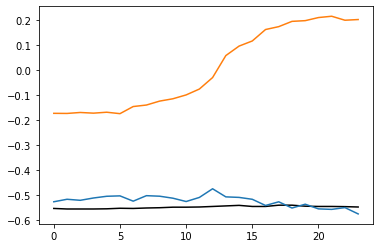

In [290]:

plt.plot(dd1_array.detach().numpy(), c='k')
plt.plot(new_pred_24h[:,0].detach().numpy())
plt.plot(pred_24h[:,0].detach().numpy())  

In [223]:
trainer.train_and_validate()

# Epoch 1:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 1: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s, Loss: 0.8434]
2022-02-17 11:43:00,458: Epoch 1 average loss: 0.9051135074008595
# Epoch 2:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 2: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s, Loss: 0.4320]
2022-02-17 11:43:04,618: Epoch 2 average loss: 0.6576044153083455
# Epoch 3:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 3: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.4239]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 3: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.4239]
2022-02-17 11:43:08,744: Epoch 3 average loss: 0.5497382472861897
# Epoch 4:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 4: 100%|██████████| 11/11 [00:04<00:00,  3.03it/s, Loss: 0.5734]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 4: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.5734]
2022-02-17 11:43:12,865: Epoch 4 average loss: 0.5154290984977375
# Epoch 5:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 5: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.6620]
2022-02-17 11:43:16,983: Epoch 5 average loss: 0.4810669449242679
# Validation: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
2022-02-17 11:43:18,663: Epoch 5 average validation loss: 0.28264 -- Median validation metrics: NSE_1H: 0.49883, NSE_1D: 0.54974
# Epoch 6:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 6: 100%|██████████| 11/11 [00:04<00:00,  2.95it/s, Loss: 0.5652]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 6: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s, Loss: 0.5652]
2022-02-17 11:43:22,933: Epoch 6 average loss: 0.43417353521693836
# Epoch 7:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 7: 100%|██████████| 11/11 [00:04<00:00,  2.62it/s, Loss: 0.4111]
2022-02-17 11:43:27,151: Epoch 7 average loss: 0.40168279951268976
# Epoch 8:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 8: 100%|██████████| 11/11 [00:04<00:00,  2.65it/s, Loss: 0.3382]
2022-02-17 11:43:31,320: Epoch 8 average loss: 0.39800375970927154
# Epoch 9:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 9: 100%|██████████| 11/11 [00:04<00:00,  3.02it/s, Loss: 0.3246]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 9: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s, Loss: 0.3246]
2022-02-17 11:43:35,614: Epoch 9 average loss: 0.3880440646951849
# Epoch 10:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 10: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s, Loss: 0.3018]
2022-02-17 11:43:39,802: Epoch 10 average loss: 0.3696336908773942
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
2022-02-17 11:43:40,449: Epoch 10 average validation loss: 0.24880 -- Median validation metrics: NSE_1H: 0.54019, NSE_1D: 0.63311
# Epoch 11:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 11: 100%|██████████| 11/11 [00:04<00:00,  3.02it/s, Loss: 0.6148]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 11: 100%|██████████| 11/11 [00:04<00:00,  2.65it/s, Loss: 0.6148]
2022-02-17 11:43:44,608: Epoch 11 average loss: 0.369941383600235
# Epoch 12:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 12: 100%|██████████| 11/11 [00:04<00:00,  3.06it/s, Loss: 0.4851]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 12: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.4851]
2022-02-17 11:43:48,753: Epoch 12 average loss: 0.36754779653115704
# Epoch 13:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 13: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.5007]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 13: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.5007]
2022-02-17 11:43:52,891: Epoch 13 average loss: 0.34710176289081573
# Epoch 14:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 14: 100%|██████████| 11/11 [00:04<00:00,  3.06it/s, Loss: 0.4254]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 14: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.4254]
2022-02-17 11:43:57,035: Epoch 14 average loss: 0.32883882793513214
# Epoch 15:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 15: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.3811]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 15: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.3811]
2022-02-17 11:44:01,150: Epoch 15 average loss: 0.33419162170453504
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]
2022-02-17 11:44:01,812: Epoch 15 average validation loss: 0.22951 -- Median validation metrics: NSE_1H: 0.56797, NSE_1D: 0.66355
# Epoch 16:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 16: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.3965]
2022-02-17 11:44:05,939: Epoch 16 average loss: 0.30338090658187866
# Epoch 17:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 17: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.2313]
2022-02-17 11:44:10,083: Epoch 17 average loss: 0.3004616471854123
# Epoch 18:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 18: 100%|██████████| 11/11 [00:04<00:00,  3.12it/s, Loss: 0.3324]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 18: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.3324]
2022-02-17 11:44:14,184: Epoch 18 average loss: 0.29467474872415717
# Epoch 19:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 19: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.3768]
2022-02-17 11:44:18,285: Epoch 19 average loss: 0.27644162286411633
# Epoch 20:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 20: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.1267]
2022-02-17 11:44:22,421: Epoch 20 average loss: 0.2566983279856769
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
2022-02-17 11:44:23,069: Epoch 20 average validation loss: 0.20793 -- Median validation metrics: NSE_1H: 0.63625, NSE_1D: 0.68148
# Epoch 21:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 21: 100%|██████████| 11/11 [00:04<00:00,  2.61it/s, Loss: 0.2690]
2022-02-17 11:44:27,308: Epoch 21 average loss: 0.2703783336010846
# Epoch 22:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 22: 100%|██████████| 11/11 [00:04<00:00,  3.02it/s, Loss: 0.2558]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 22: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s, Loss: 0.2558]
2022-02-17 11:44:31,499: Epoch 22 average loss: 0.2587499835274436
# Epoch 23:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 23: 100%|██████████| 11/11 [00:04<00:00,  3.04it/s, Loss: 0.3369]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 23: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s, Loss: 0.3369]
2022-02-17 11:44:35,653: Epoch 23 average loss: 0.2575817663561214
# Epoch 24:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 24: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.2905]
2022-02-17 11:44:39,799: Epoch 24 average loss: 0.2410585406151685
# Epoch 25:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 25: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.2850]
2022-02-17 11:44:43,939: Epoch 25 average loss: 0.25575169785456225
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
2022-02-17 11:44:44,701: Epoch 25 average validation loss: 0.18906 -- Median validation metrics: NSE_1H: 0.63393, NSE_1D: 0.70815
# Epoch 26:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 26: 100%|██████████| 11/11 [00:04<00:00,  2.64it/s, Loss: 0.1937]
2022-02-17 11:44:48,881: Epoch 26 average loss: 0.251892471855337
# Epoch 27:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 27: 100%|██████████| 11/11 [00:04<00:00,  3.11it/s, Loss: 0.1435]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 27: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.1435]
2022-02-17 11:44:53,022: Epoch 27 average loss: 0.23293233866041357
# Epoch 28:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 28: 100%|██████████| 11/11 [00:04<00:00,  2.65it/s, Loss: 0.1690]
2022-02-17 11:44:57,193: Epoch 28 average loss: 0.230271268974651
# Epoch 29:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 29: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s, Loss: 0.1679]
2022-02-17 11:45:01,349: Epoch 29 average loss: 0.23443296958099713
2022-02-17 11:45:01,357: Setting learning rate to 0.005
# Epoch 30:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 30: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.2153]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 30: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.2153]
2022-02-17 11:45:05,481: Epoch 30 average loss: 0.21280017359690231
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
2022-02-17 11:45:06,122: Epoch 30 average validation loss: 0.17881 -- Median validation metrics: NSE_1H: 0.67462, NSE_1D: 0.70788
# Epoch 31:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 31: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.2182]
2022-02-17 11:45:10,209: Epoch 31 average loss: 0.21449311483990063
# Epoch 32:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 32: 100%|██████████| 11/11 [00:04<00:00,  2.58it/s, Loss: 0.2446]
2022-02-17 11:45:14,493: Epoch 32 average loss: 0.21102078665386548
# Epoch 33:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 33: 100%|██████████| 11/11 [00:04<00:00,  2.68it/s, Loss: 0.2678]
2022-02-17 11:45:18,623: Epoch 33 average loss: 0.21716924011707306
# Epoch 34:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 34: 100%|██████████| 11/11 [00:04<00:00,  3.08it/s, Loss: 0.1645]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 34: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.1645]
2022-02-17 11:45:22,767: Epoch 34 average loss: 0.1989688534628261
# Epoch 35:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 35: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.1824]
2022-02-17 11:45:26,864: Epoch 35 average loss: 0.2051033011891625
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
2022-02-17 11:45:27,506: Epoch 35 average validation loss: 0.18555 -- Median validation metrics: NSE_1H: 0.66033, NSE_1D: 0.70617
# Epoch 36:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 36: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.1883]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 36: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.1883]
2022-02-17 11:45:31,615: Epoch 36 average loss: 0.20543552257797934
# Epoch 37:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 37: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.2173]
2022-02-17 11:45:35,720: Epoch 37 average loss: 0.19220046292651782
# Epoch 38:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 38: 100%|██████████| 11/11 [00:04<00:00,  2.70it/s, Loss: 0.2211]
2022-02-17 11:45:39,823: Epoch 38 average loss: 0.20778737826780838
# Epoch 39:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 39: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.1636]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 39: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.1636]
2022-02-17 11:45:43,939: Epoch 39 average loss: 0.19071454757993872
2022-02-17 11:45:43,947: Setting learning rate to 0.001
# Epoch 40:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 40: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.1847]
2022-02-17 11:45:48,063: Epoch 40 average loss: 0.19542409073222766
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
2022-02-17 11:45:48,707: Epoch 40 average validation loss: 0.17970 -- Median validation metrics: NSE_1H: 0.66749, NSE_1D: 0.71208
# Epoch 41:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 41: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s, Loss: 0.1739]
2022-02-17 11:45:52,781: Epoch 41 average loss: 0.1892206533388658
# Epoch 42:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 42: 100%|██████████| 11/11 [00:04<00:00,  3.09it/s, Loss: 0.2254]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


# Epoch 42: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.2254]
2022-02-17 11:45:56,905: Epoch 42 average loss: 0.18786140328103845
# Epoch 43:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 43: 100%|██████████| 11/11 [00:04<00:00,  2.63it/s, Loss: 0.1289]
2022-02-17 11:46:01,121: Epoch 43 average loss: 0.177114414897832
# Epoch 44:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 44: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s, Loss: 0.3400]
2022-02-17 11:46:05,286: Epoch 44 average loss: 0.19543106041171335
# Epoch 45:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 45: 100%|██████████| 11/11 [00:04<00:00,  2.71it/s, Loss: 0.1664]
2022-02-17 11:46:09,365: Epoch 45 average loss: 0.1893347759138454
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]
2022-02-17 11:46:10,011: Epoch 45 average validation loss: 0.17729 -- Median validation metrics: NSE_1H: 0.67210, NSE_1D: 0.71434
# Epoch 46:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 46: 100%|██████████| 11/11 [00:04<00:00,  2.69it/s, Loss: 0.2264]
2022-02-17 11:46:14,122: Epoch 46 average loss: 0.1898575100031766
# Epoch 47:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 47: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.1664]
2022-02-17 11:46:18,261: Epoch 47 average loss: 0.17946001209995963
# Epoch 48:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 48: 100%|██████████| 11/11 [00:04<00:00,  2.67it/s, Loss: 0.1682]
2022-02-17 11:46:22,406: Epoch 48 average loss: 0.18066004731438376
# Epoch 49:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 49: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s, Loss: 0.1724]
2022-02-17 11:46:26,565: Epoch 49 average loss: 0.18465721742673355
# Epoch 50:   0%|          | 0/11 [00:00<?, ?it/s]

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

# Epoch 50: 100%|██████████| 11/11 [00:04<00:00,  2.65it/s, Loss: 0.2008]
2022-02-17 11:46:30,744: Epoch 50 average loss: 0.18731968240304428
# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]
2022-02-17 11:46:31,394: Epoch 50 average validation loss: 0.17594 -- Median validation metrics: NSE_1H: 0.67443, NSE_1D: 0.71587


In [228]:
new_pred = trainer.model(dd1)

In [229]:
myloss(new_pred, dd1)

tensor(0.0542, grad_fn=<SumBackward0>)

In [230]:
myloss(pred, dd1)

tensor(1.0621, grad_fn=<SumBackward0>)

In [231]:
trainer.loss_obj(new_pred, dd1)

tensor(0.0689, grad_fn=<AddBackward0>)

In [233]:
len(ds)

2739